In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
import catboost as cb

import pickle
from urllib.parse import urlparse

In [14]:
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, ColSpec
from mlflow.models import infer_signature

In [15]:
import pandas as pd

# Setup MLFLOW

In [16]:
import mlflow
import mlflow.sklearn
mlflow.set_experiment('Employee-Burn-Out-Project')

<Experiment: artifact_location='file:///d:/Users/user/mlops/work_burn_out/mlruns/236899882022349001', creation_time=1721984171432, experiment_id='236899882022349001', last_update_time=1721984171432, lifecycle_stage='active', name='Employee-Burn-Out-Project', tags={}>

# Read Data

In [17]:
train=pd.read_csv(r'D:/Users/user/mlops/work_burn_out/data/train.csv')
test=pd.read_csv(r'D:/Users/user/mlops/work_burn_out/data/test.csv')

# Analyze Data

In [18]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [19]:
print('number of columns',len(train.columns))
print('columns are:',train.columns)

number of columns 9
columns are: Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [21]:
train.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [ ]:
train.rename(columns={'WFH Setup Available': 'Remote','Resource Allocation':'Resource'}, inplace=True)

In [22]:
male=len(train[train['Gender']=='Male'])
female=len(train[train['Gender']=='Female'])
print('number of males:',male)
print('number of females:',female)

number of males: 10842
number of females: 11908


In [23]:
product=len(train[train['Company Type']=='Product'])
service=len(train[train['Company Type']=='Service'])
print('number of product companies:',product)
print('number of service companies:',service)

number of product companies: 7917
number of service companies: 14833


In [28]:
remote=len(train[train['Remote']=='Yes'])
onsite=len(train[train['Remote']=='No'])
print('number of remote companies:',remote)
print('number of onsite companies:',onsite)

number of remote companies: 12290
number of onsite companies: 10460


# Preprocessing
**1. remove duplicates**

**2. drop Employee ID**

**3. rename columns**



In [25]:
train.drop_duplicates(inplace=True)

In [26]:
train=train.drop('Employee ID',axis=1)

In [ ]:
train['Mental Fatigue Score'].value_counts()

Mental Fatigue Score
6.0    470
5.8    464
5.9    458
6.1    457
6.3    454
      ... 
0.5     24
0.2     23
0.4     19
0.1     17
0.3     13
Name: count, Length: 101, dtype: int64

In [ ]:
train.columns

Index(['Date of Joining', 'Gender', 'Company Type', 'Remote', 'Designation',
       'Resource', 'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [ ]:
train['Designation'].value_counts()

Designation
2.0    7588
3.0    5985
1.0    4881
4.0    2391
0.0    1507
5.0     398
Name: count, dtype: int64

In [ ]:
train['Resource'].value_counts()

Resource
4.0     3893
5.0     3861
3.0     3192
6.0     2943
2.0     2075
7.0     1965
1.0     1791
8.0     1044
9.0      446
10.0     159
Name: count, dtype: int64

# Encoding
# **Categorical data:**
Date of Joining, Gender, Company Type, WFH Setup Available
# **Numerical data:**
Designation, Resource Allocation, Mental Fatigue Score, Burn Rate

In [ ]:
train['Gender'] = train['Gender'].replace({'Male': 1,'Female': 0})
train['Company Type'] = train['Company Type'].replace({'Service': 1, 'Product': 0})
train['Remote'] = train['Remote'].replace({'Yes': 1, 'No': 0})

In [ ]:
print(train['Date of Joining'].min(),'\n'+str(train['Date of Joining'].max()))

2008-01-01 
2008-12-31


In [ ]:
#difference between the time employee arrived and the time of the survay which is 2020 kis 4 years
date=np.ones((len(train['Date of Joining']),1))
train['Work Period']=date*12

In [ ]:
#no need for the date of joining column any more
train=train.drop('Date of Joining',axis=1)

# Handle missing data

In [ ]:
mfs=train['Mental Fatigue Score'].isna().sum()/len(train['Mental Fatigue Score'])*100
res=train['Resource'].isna().sum()/len(train['Resource'])*100
br=train['Resource'].isna().sum()/len(train['Burn Rate'])*100


print('mental fatigue score null values percent is : '+str(mfs)+' %')
print('resource null values percent is : '+str(res)+' %')
print('Burn Rate null values percent is : '+str(br)+' %')

mental fatigue score null values percent is : 9.291996481970097 %
resource null values percent is : 6.072999120492524 %
Burn Rate null values percent is : 6.072999120492524 %


In [ ]:
train.dropna(inplace=True)

# **Data Visulaization**

C:\Users\Windows.10\AppData\Local\Temp\ipykernel_14300\3601930032.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


[Text(0, 0, 'Designation'),
 Text(1, 0, 'Resource'),
 Text(2, 0, 'Mental Fatigue Score')]

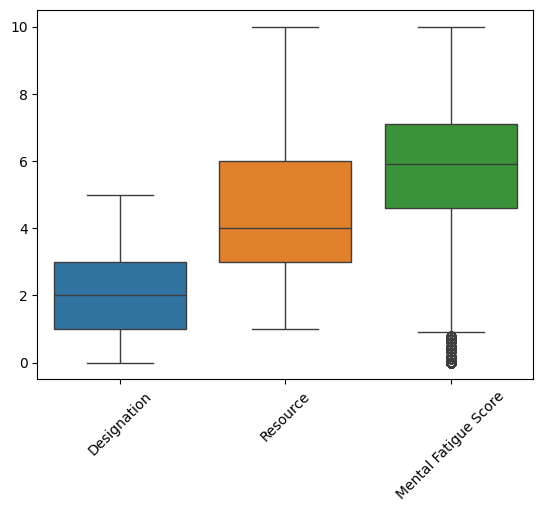

In [ ]:
ax=sns.boxplot([train['Designation'],train['Resource'],train['Mental Fatigue Score']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<Axes: >

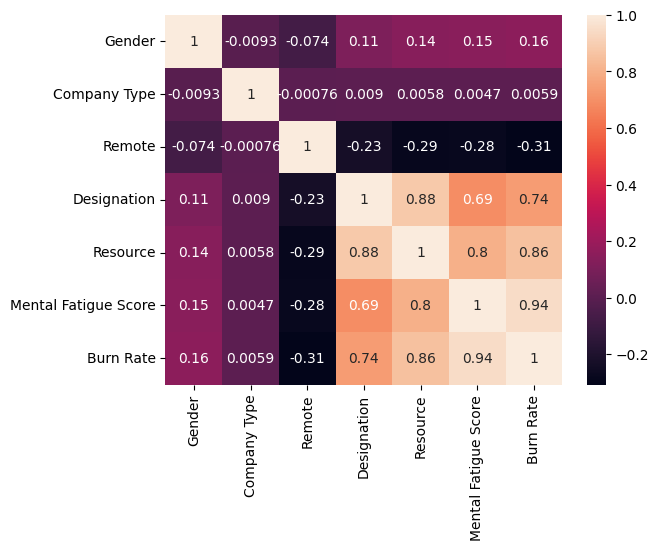

In [ ]:
sns.heatmap(train.drop('Work Period',axis=1).corr(), annot=True)

Text(0.5, 1.0, 'remote/burn out rate')

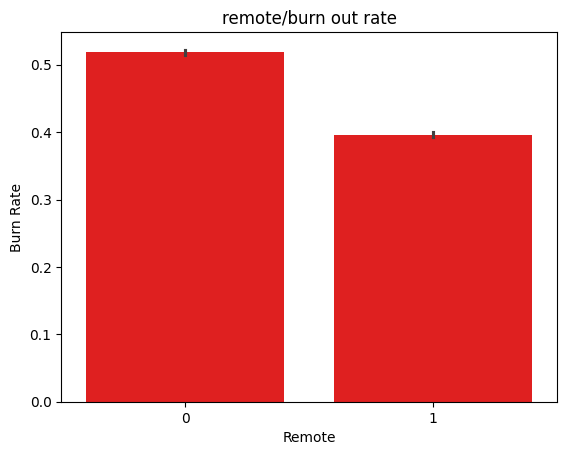

In [ ]:
sns.barplot(data=train,x='Remote',y='Burn Rate',color='red')
plt.title('remote/burn out rate')

In [ ]:
#burn out is reduced with remote jobs

<Axes: xlabel='Designation', ylabel='Burn Rate'>

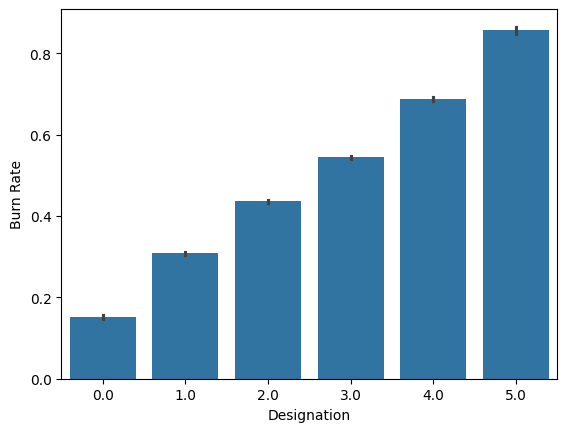

In [ ]:
sns.barplot(data=train,x='Designation',y='Burn Rate')

In [ ]:
#burn out rate increases with seniority

<Axes: xlabel='Resource', ylabel='Burn Rate'>

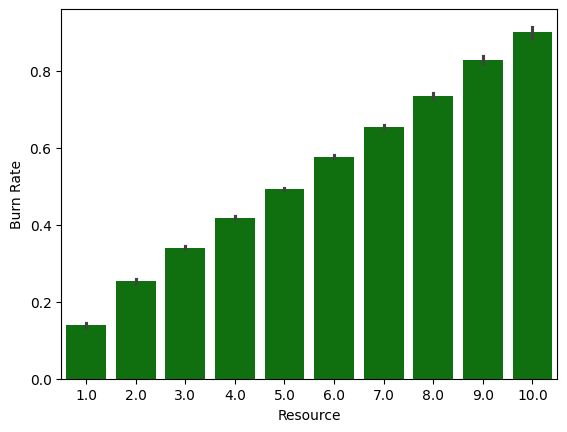

In [ ]:
sns.barplot(data=train,x='Resource',y='Burn Rate',color='green')

In [ ]:
#employee having more resources means more burn out rate

c:\Users\Windows.10\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Mental Fatigue Score', ylabel='Burn Rate'>

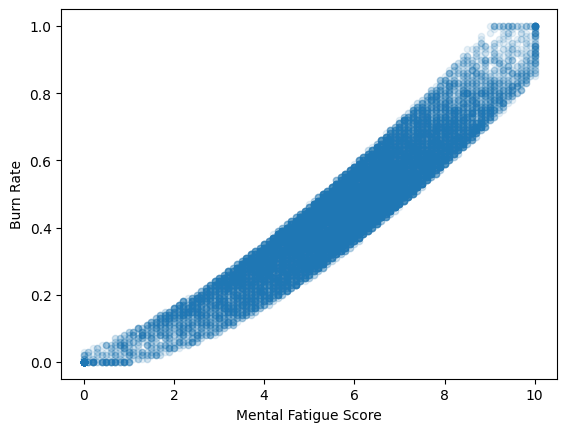

In [ ]:
train.plot(kind="scatter", x="Mental Fatigue Score", y="Burn Rate", cmap="jet",
legend=True, sharex=False, alpha=0.1)

In [ ]:
#relationship between burn out rate and mental fatigue score is almost linear meaning the burn out increases when mental fatigue increases

<Axes: xlabel='Gender', ylabel='Resource'>

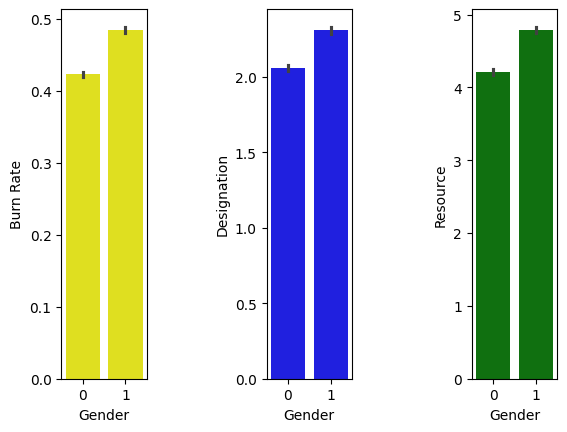

In [ ]:
plt.subplot(1,5,1)
sns.barplot(data=train,x='Gender',y='Burn Rate',color='yellow')
plt.subplot(1,5,3)
sns.barplot(data=train,x='Gender',y='Designation',color='blue')
plt.subplot(1,5,5)
sns.barplot(data=train,x='Gender',y='Resource',color='green')

In [ ]:
#males suffer more burn out but males also more seniority and more resources

<Axes: xlabel='Company Type', ylabel='Burn Rate'>

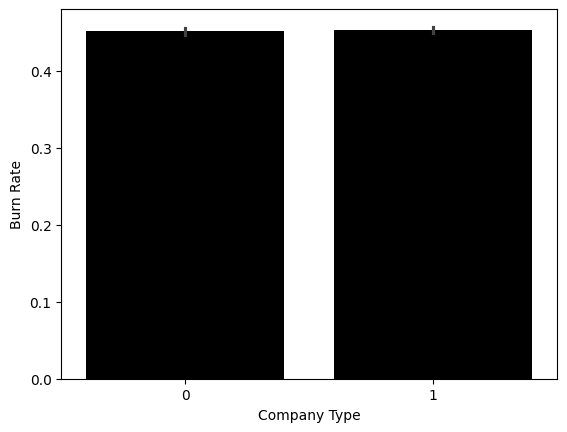

In [ ]:
sns.barplot(data=train,x='Company Type',y='Burn Rate',color='black')

In [ ]:
#there is not much difference with the type of comapny

([<matplotlib.patches.Wedge at 0x27f5e832c60>,
 [Text(0.08394193504247317, 1.096792483353768, 'male'),
  Text(-0.08394183235334986, -1.0967924912129743, 'female')])

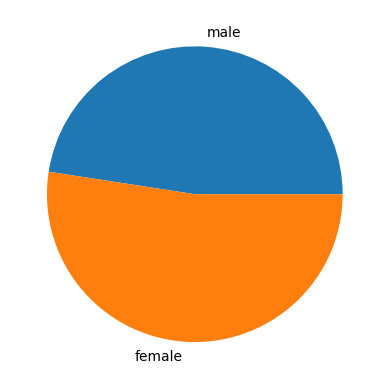

In [ ]:
plt.pie(x=[male,female],labels=['male','female'])

([<matplotlib.patches.Wedge at 0x245fa71ff20>,
 [Text(0.5055378774171093, 0.9769500777913905, 'Product'),
  Text(-0.505537877417109, -0.9769500777913906, 'Service')])

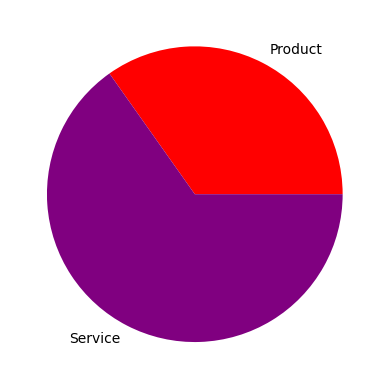

In [ ]:
plt.pie(x=[product,service],labels=['Product','Service'],colors=['red','purple'])

([<matplotlib.patches.Wedge at 0x245f5176ea0>,
 [Text(-0.1386200531985119, 1.0912307184327437, 'Remote'),
  Text(0.138620053198512, -1.0912307184327437, 'Onsite')])

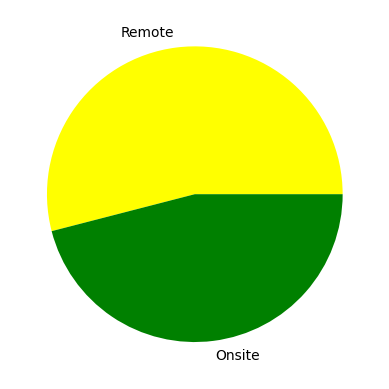

In [ ]:
plt.pie(x=[remote,onsite],labels=['Remote','Onsite'],colors=['yellow','green'])

# **Training**

In [ ]:
X=train.drop('Burn Rate',axis=1)
Y=train['Burn Rate']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
train_dataset = cb.Pool(x_train, y_train)
test_dataset = cb.Pool(x_test, y_test)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03,0.5, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 0.4814115	test: 0.4748123	best: 0.4748123 (0)	total: 202ms	remaining: 20s
1:	learn: 0.4677582	test: 0.4612425	best: 0.4612425 (1)	total: 210ms	remaining: 10.3s
2:	learn: 0.4549562	test: 0.4485378	best: 0.4485378 (2)	total: 221ms	remaining: 7.13s
3:	learn: 0.4421146	test: 0.4358533	best: 0.4358533 (3)	total: 242ms	remaining: 5.8s
4:	learn: 0.4297688	test: 0.4236481	best: 0.4236481 (4)	total: 274ms	remaining: 5.21s
5:	learn: 0.4177038	test: 0.4116538	best: 0.4116538 (5)	total: 300ms	remaining: 4.7s
6:	learn: 0.4061241	test: 0.4001380	best: 0.4001380 (6)	total: 317ms	remaining: 4.21s
7:	learn: 0.3947949	test: 0.3888606	best: 0.3888606 (7)	total: 336ms	remaining: 3.87s
8:	learn: 0.3836234	test: 0.3777802	best: 0.3777802 (8)	total: 345ms	remaining: 3.49s
9:	learn: 0.3728343	test: 0.3670073	best: 0.3670073 (9)	total: 352ms	remaining: 3.17s
10:	learn: 0.3625199	test: 0.3567544	best: 0.3567544 (10)	total: 357ms	remaining: 2.88s
11:	learn: 0.3523961	test: 0.3466976	best: 0.3466976 (11

{'params': {'depth': 6,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [ ]:
rf= RandomForestRegressor(random_state=42)
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

# Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def cross_validation(model,input_data=x_train,lable=y_train,scoring_='neg_root_mean_squared_error'):
  return -cross_val_score(model, input_data, lable,
                          scoring=scoring_)

In [ ]:
linear_regression_rmse=cross_validation(lr)

In [ ]:
linear_regression_rmse

array([0.05598158, 0.05610385, 0.05635451, 0.05560199, 0.05522109])

In [ ]:
lr_pred=lr.predict(x_test)

# **mean square error**

# linear regression

In [ ]:
mean_squared_error(y_test,lr_pred)

0.0030638579021906114

# random forest

In [ ]:
mean_squared_error(y_test,rf.predict(x_test))

0.0033694226458284445

# catboost

In [ ]:
mean_squared_error(y_test, model.predict(x_test))

0.0028064685464026127

# Save model

In [ ]:
pickle.dump(model , open('burn-out-model.pk1' , 'wb'))

In [ ]:
loaded_model = pickle.load(open('burn-out-model.pk1' , 'rb'))

# Burn out rate prediction

In [ ]:
pred=model.predict(x_test)

In [ ]:
x_test.head(1)

c:\Users\Windows.10\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Gender,Company Type,Remote,Designation,Resource,Mental Fatigue Score,Work Period
8815,1,1,1,1.0,2.0,3.9,4.0


In [ ]:
print('employee',8815,'burn out rate is',round(pred[0]*100,2),'%')

employee 8815 burn out rate is 26.34 %


(array([132., 226., 426., 618., 793., 688., 463., 246.,  87.,  39.]),
 array([-0.271902  ,  9.75147565, 19.77485329, 29.79823093, 39.82160857,
        49.84498621, 59.86836386, 69.8917415 , 79.91511914, 89.93849678,
        99.96187443]),
 <BarContainer object of 10 artists>)

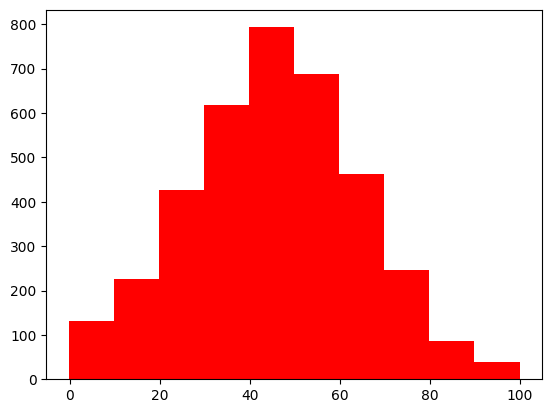

In [ ]:
plt.hist(pred*100,color='red')

# Test the insights

In [ ]:
train['Resource'].value_counts()

Resource
4.0     3396
5.0     3364
3.0     2761
6.0     2590
2.0     1794
7.0     1697
1.0     1551
8.0      907
9.0      396
10.0     134
Name: count, dtype: int64

In [ ]:
'''an employee:
1. is a male=1
2. the Company Type is service=1
3. work is not remote=0
4. Designation is high=4.0
5. have high resource=8
6. Mental Fatigue Score =8.0'''
gender=1
company_type=1
remote=0
designation=4.0
resource=8
mental_fatigue_score=8.0
work_period=4.0

data=[gender,company_type,remote,designation,resource,mental_fatigue_score,work_period]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 72.6 %


In [ ]:
#for a female
data=[0,1,0,4.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 72.47 %


In [ ]:
#remote work
data=[1,1,1,4.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 70.43 %


In [ ]:
#remote work , designation low, resource high
data=[1,1,1,2.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 77.47 %


In [ ]:
#female, remote work , designation low, resource high
data=[0,1,1,2.0,8.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 76.75 %


In [ ]:
#female, remote work , designation low, resource low
data=[0,1,1,2.0,2.0,8.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 48.07 %


In [ ]:
#female, remote work , designation low, resource low,low mental fatigue
data=[0,1,1,2.0,2.0,2.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 12.91 %


In [ ]:
#female, remote work , designation low, resource low
data=[0,1,1,1.0,1.0,1.0,4.0]
print('Burn out rate is:',round(model.predict(data)*100,2),'%')

Burn out rate is: 3.31 %


In [ ]:
test_data=np.array([[1,1,0,4.0,8,8.0,4.0],[0,1,0,4.0,8.0,8.0,4.0],[1,1,1,4.0,8.0,8.0,4.0],
  [1,1,1,2.0,8.0,8.0,4.0],[0,1,1,2.0,8.0,8.0,4.0],[0,1,1,2.0,2.0,8.0,4.0],
  [0,1,1,2.0,2.0,2.0,4.0],[0,1,1,1.0,1.0,1.0,4.0]])

In [ ]:
test=pd.DataFrame(test_data,columns=['Gender','Company Type','Remote','Designation','Resource','Mental Fatigue Score','Work Period'])

In [ ]:
predictions=model.predict(test)

In [ ]:
test['predictions']=predictions*100

In [ ]:
test.head(8)

c:\Users\Windows.10\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
c:\Users\Windows.10\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Gender,Company Type,Remote,Designation,Resource,Mental Fatigue Score,Work Period,predictions
0,1.0,1.0,0.0,4.0,8.0,8.0,4.0,72.603221
1,0.0,1.0,0.0,4.0,8.0,8.0,4.0,72.471930
2,1.0,1.0,1.0,4.0,8.0,8.0,4.0,70.432557
3,1.0,1.0,1.0,2.0,8.0,8.0,4.0,77.472639
4,0.0,1.0,1.0,2.0,8.0,8.0,4.0,76.748176
5,0.0,1.0,1.0,2.0,2.0,8.0,4.0,48.071661
6,0.0,1.0,1.0,2.0,2.0,2.0,4.0,12.909549
7,0.0,1.0,1.0,1.0,1.0,1.0,4.0,3.313869


# MLflow

In [ ]:
def calculate_rmse(actual_values, predicted_values):
    """
    Calculate the Root Mean Square Error (RMSE) between actual_values and predicted_values.
    
    Parameters:
    - actual_values: Array-like object containing the actual values.
    - predicted_values: Array-like object containing the predicted values.
    
    Returns:
    - rmse: The Root Mean Square Error as a float.
    """
    # Ensure inputs are NumPy arrays
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)
    
    # Calculate the difference between actual and predicted values
    differences = actual_values - predicted_values
    
    # Square the differences
    squared_differences = differences ** 2
    
    # Calculate the mean of the squared differences
    mean_squared_difference = np.mean(squared_differences)
    
    # Take the square root of the mean squared difference to get RMSE
    rmse = np.sqrt(mean_squared_difference)
    
    return rmse

In [ ]:
with mlflow.start_run():
    model = cb.CatBoostRegressor(loss_function='RMSE')
    model.fit(x_train,y_train)
    predict=model.predict(y_test)
    rmse=np.sqrt(calculate_rmse(y_test,predict))
    mlflow.log_metric("rmse",rmse)
    signature=infer_signature(x_train,predict)

    tracking_url_type_store=urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store!="file":
        mlflow.sklearn.log_model(model,"model",
                                 registered_model_name="Catboost", signature=signature)
    else:
        mlflow.sklearn.log_model(model,"model", signature=signature)


Learning rate set to 0.062718
0:	learn: 0.1879233	total: 7.04ms	remaining: 7.03s
1:	learn: 0.1780333	total: 16.3ms	remaining: 8.14s
2:	learn: 0.1691875	total: 23.6ms	remaining: 7.83s
3:	learn: 0.1605152	total: 29.4ms	remaining: 7.32s
4:	learn: 0.1525633	total: 37ms	remaining: 7.37s
5:	learn: 0.1453614	total: 41.9ms	remaining: 6.95s
6:	learn: 0.1382794	total: 48.9ms	remaining: 6.93s
7:	learn: 0.1317246	total: 55.3ms	remaining: 6.86s
8:	learn: 0.1255006	total: 60ms	remaining: 6.6s
9:	learn: 0.1197139	total: 152ms	remaining: 15.1s
10:	learn: 0.1144228	total: 224ms	remaining: 20.1s
11:	learn: 0.1094328	total: 239ms	remaining: 19.7s
12:	learn: 0.1047823	total: 250ms	remaining: 19s
13:	learn: 0.1006108	total: 347ms	remaining: 24.5s
14:	learn: 0.0966887	total: 356ms	remaining: 23.4s
15:	learn: 0.0929506	total: 367ms	remaining: 22.6s
16:	learn: 0.0895477	total: 464ms	remaining: 26.8s
17:	learn: 0.0864440	total: 473ms	remaining: 25.8s
18:	learn: 0.0835744	total: 488ms	remaining: 25.2s
19:	learn

c:\Users\Windows.10\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
